# Data100 Final Project - Predicting Championship Success
### Angela Chen, Vera Wang, Michelle Li

The goal of our project is to understand basketball teams that make it to the championships. What elements do these teams have in common? Do they have a specific strategy, a similar winning pattern, or the same types of players? Or, are these teams making it to the championships based on random factors/factors that cannot be quantitatively measured? We start off with cleaning our data to be more easily readable, and then we do some exploratory data analysis to better understand trends within the games. Next, we will analyze what factors (if any) are common between the teams that end up at the champsionships. Finally, we will try to use these factors to predict what teams will win the championships.

## Set up and Data Cleaning

In [1]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile
from pathlib import Path

Path.cwd()

PosixPath('/home/jovyan')

In [2]:
#Loading in dataset
standings = pd.read_csv("Standings.csv")
collegeset = pd.read_csv("college.csv")
box_score = pd.read_csv("Basketball-BoxScores.csv")
player_box_score = pd.read_csv("Basketball-PlayerBoxScore.csv")
team_box_score = pd.read_csv("Basketball-TeamBoxScores.csv")

In [8]:
#Cleaning college dataset 
college = collegeset.drop(columns = 'Unnamed: 0')
college = college.rename(columns = {'NBA_g_played': 'NBA_games', 'NCAA_fgpct' : 'NCAA_fg%'})
college = college[college['active_from'] > 2011]

In [11]:
#Cleaning player box score dataset 
player_box_score = player_box_score.rename(columns = {'playDispNm': 'name', 'playPos': 'pos', 'playHeight': 'height', 'playWeight': 'weight'})

## Part 1: Exploratory Data Analysis

Before diving into the different factors, we wanted to do some EDA to see if we could find any initial trends that really stood out to us (which could give us a "lead" on which factors to focus on). 

The first thing we wanted to do was to look at which teams had the most wins. Since the standings tables recorded the same amount of entries for each team, we can look at the raw numbers of wins instead of proportions.

In [12]:
wins = standings[standings['stkType'] == 'win']
byteam = wins.groupby('teamAbbr').size().sort_values(ascending = False)
tophalf = byteam.head(15)
tophalf

teamAbbr
GS     726
SA     702
HOU    637
LAC    635
OKC    622
TOR    598
MIA    563
IND    562
POR    555
BOS    541
CLE    537
MEM    526
CHI    516
ATL    508
UTA    505
dtype: int64

### Player Information

What do these teams have in common? Our initial instinct was to look at the player information, since it makes sense that good teams would have good players. We joined the tables with the players college information, their box scores, and their profession team standings. We then created visualizations.

We looked at which colleges were most prevalent amongst the players who were part of the top five teams.

In [13]:
playerinfo = pd.merge(player_box_score[['name', 'teamAbbr']], college[['name', 'college','NCAA_fg%', 'NBA_fg%']], how = 'inner', on = 'name').drop_duplicates('name')

Text(0.5, 1.0, 'Top Colleges Attended by Players in Top Teams')

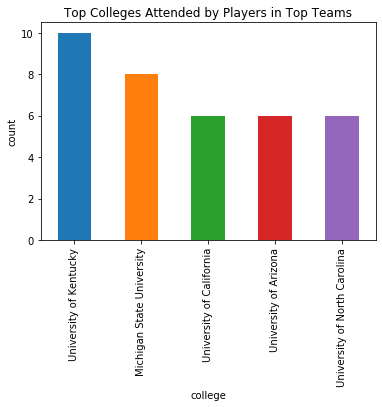

In [26]:
players_in_top_teams = playerinfo[playerinfo['teamAbbr'].isin(np.array(tophalf.index))]
topcolleges = players_in_top_teams.groupby('college').size().sort_values(ascending = False).head(5)
topcolleges.plot(kind = 'bar', x = 'college')
plt.ylabel('count')
plt.title('Top Colleges Attended by Players in Top Teams')

We also looked at the distribution of games played to see if successful teams necessarily had more veteran players, or if novice players also had a good chance of being on some of the top teams. We looked at NCAA games only, because we wannted to focus on how many games the players played before they were signed onto an NBA team. 

(0, 1)

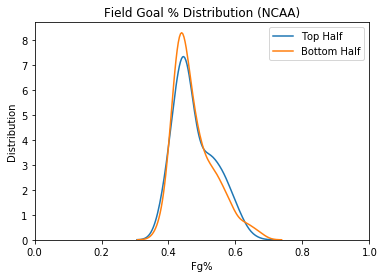

In [38]:
players_in_bottom_teams = playerinfo[~playerinfo['teamAbbr'].isin(np.array(tophalf.index))]
topteamsncaa = players_in_top_teams['NCAA_fg%']
bottomteamsncaa = players_in_bottom_teams['NCAA_fg%']

sns.distplot(topgames, hist = False, label = 'Top Half')
sns.distplot(bottomgames, hist = False, label = 'Bottom Half')
plt.xlabel('Fg%')
plt.ylabel('Distribution')
plt.title('Field Goal % Distribution (NCAA)')
plt.xlim(0, 1)

(0, 1)

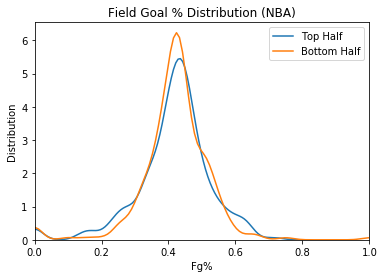

In [42]:
topteamsnba = players_in_top_teams['NBA_fg%']
bottomteamsnba = players_in_bottom_teams['NBA_fg%']

sns.distplot(topteamsnba, hist = False, label = 'Top Half')
sns.distplot(bottomteamsnba, hist = False, label = 'Bottom Half')
plt.xlabel('Fg%')
plt.ylabel('Distribution')
plt.title('Field Goal % Distribution (NBA)')
plt.xlim(0, 1)

### Game Information

Besides the players, the top teams probably have some type of strategy or gameplay they follow that helps them be successful. Although we aren't able to access the specific details of their game strategy, we can analyze information from the games themselves to see if there are any common patterns.

In [15]:
playoffs1718 = ["HOU", "GS", "POR", "OKC", "UTA", "NO", "SA", "MIN", "TOR", "BOS", "PHI", "CLE", "IND", "MIA", "MIL", "WAS"]

games1718 = box_score[box_score["gmDate"]>='2017-10-17']

games1718 = games1718.groupby(["gmDate", "teamAbbr"]).mean().reset_index()
games1718["playoff_teams"] = np.where(games1718['teamAbbr'].isin(playoffs1718), 1, 0)

teamFG%          0.150744
team2P%          0.161539
teamTS%          0.167319
teamPPS          0.164800
teamFIC          0.192163
teamFIC40        0.191034
teamOrtg         0.171572
teamEDiff        0.240579
teamPlay%        0.159233
opptAST          0.154680
opptFIC          0.220046
opptFIC40        0.223797
opptDrtg         0.171572
opptEDiff        0.240579
opptAR           0.150614
playoff_teams    1.000000
Name: playoff_teams, dtype: float64


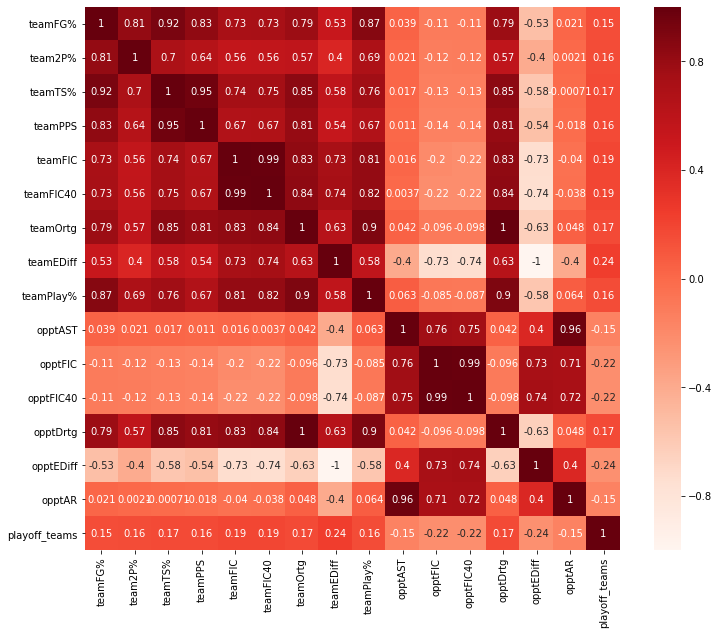

In [16]:
cor = games1718.corr()
output_var = abs(cor["playoff_teams"])

#Finding the most correlated features
relevant_features = output_var[output_var>=0.15]
print(relevant_features)

reldf = games1718[relevant_features.index]
plt.figure(figsize=(12,10))
sns.heatmap(reldf.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

## Part 2: What Factors Cause Teams to go to the Playoffs?

Now that we know a little bit more about what factors cause teams to be successful, we wanted to build a model that predicts what teams go to the championships. 

In [17]:
rel_cols = relevant_features.index
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(games1718[rel_cols], games1718["playoff_teams"])

/srv/app/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
#Change this to filter for 2016-2017 season
games1617 = box_score[box_score["gmDate"]>='2017-10-17']

Y_hat = lr_model.predict(games1617[rel_cols])
accuracy = np.mean(Y == Y_hat)
print("Prediction Accuracy:", accuracy)

KeyError: "Index(['playoff_teams'], dtype='object') not in index"

In [19]:
from sklearn import tree
dt_model = tree.DecisionTreeClassifier()
dt_model.fit(games1718[rel_cols], games1718["playoff_teams"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')